In [2]:
## This is the first ICA example
## Import the necessary libraries

import numpy as np
import matplotlib.pyplot as plt
import scipy as sp
import pandas as pd
from scipy import signal

Ok, We have this equation x=As, what it is saying is that we have some independent source signals s, they're linearly combined 
with the matrix A to give us the signal we see, x.

Now, we name inverse of the A matrix as W, and s=xW.
Starting now, we want to create some independent signals that will be mixed by the matrix A. 
The independent sources signals are (1) a sine wave, (2) a saw tooth signal and (3) a random noise vector. After calculating their dot product with A we get three linear combinations of these source signals.

In [151]:
np.random.seed(23)
ns=np.linspace(0,200,1000)
print("ns shape is",ns.shape)
## Creating the source matrix
first=np.sin(ns*1)  
second=signal.sawtooth(ns*1.9)
third=np.random.random(len(ns))
S=np.array([first,second,third])
print("S shape is",S[0].shape)
print(S.shape)
## Creating the mixing matrix
A=np.array([[0.5,1,0.2],[1,0.5,0.4],[0.5,0.8,1]])
## Now mixing the signals witht= the mixing matrix
X=np.dot(A,S)

X.shape


ns shape is (1000,)
S shape is (1000,)
(3, 1000)


(3, 1000)

Now we have a matrix which contains three different rows containing three different signals. Let's plot them to see.

Text(0.5, 1.0, 'Independent sources')

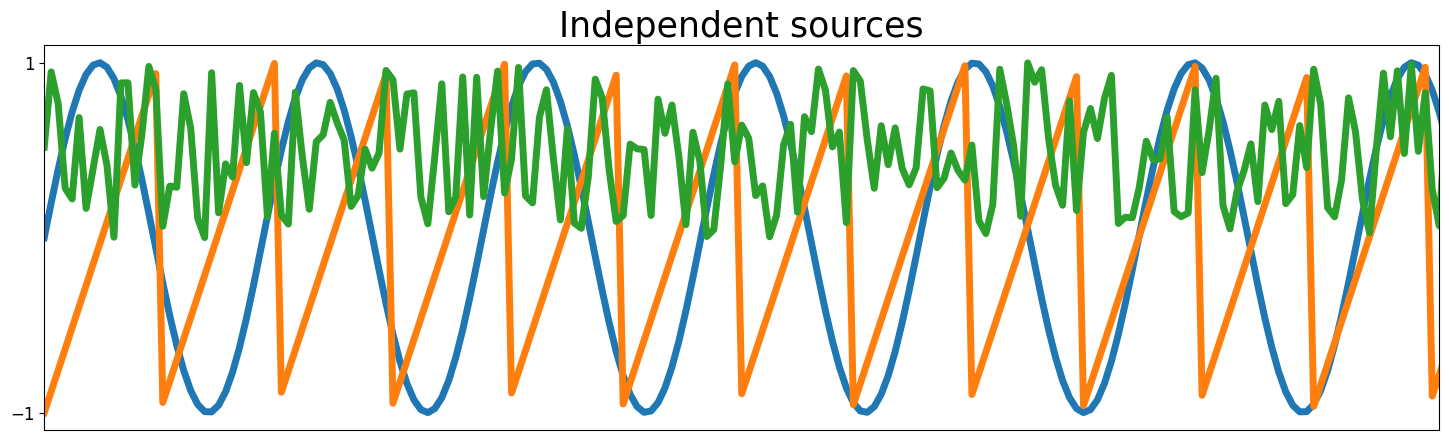

In [155]:
## Plot the first row of the source matrix X
fig, ax=plt.subplots(1,1,figsize=(18,5))
ax.plot(ns, S[0], lw=5)
ax.plot(ns, S[1], lw=5)
ax.plot(ns, S[2], lw=5)
ax.set_xticks([])
ax.set_yticks([-1, 1])
ax.set_xlim(ns[0], ns[200])
ax.tick_params(labelsize=12)
ax.set_title('Independent sources', fontsize=25)

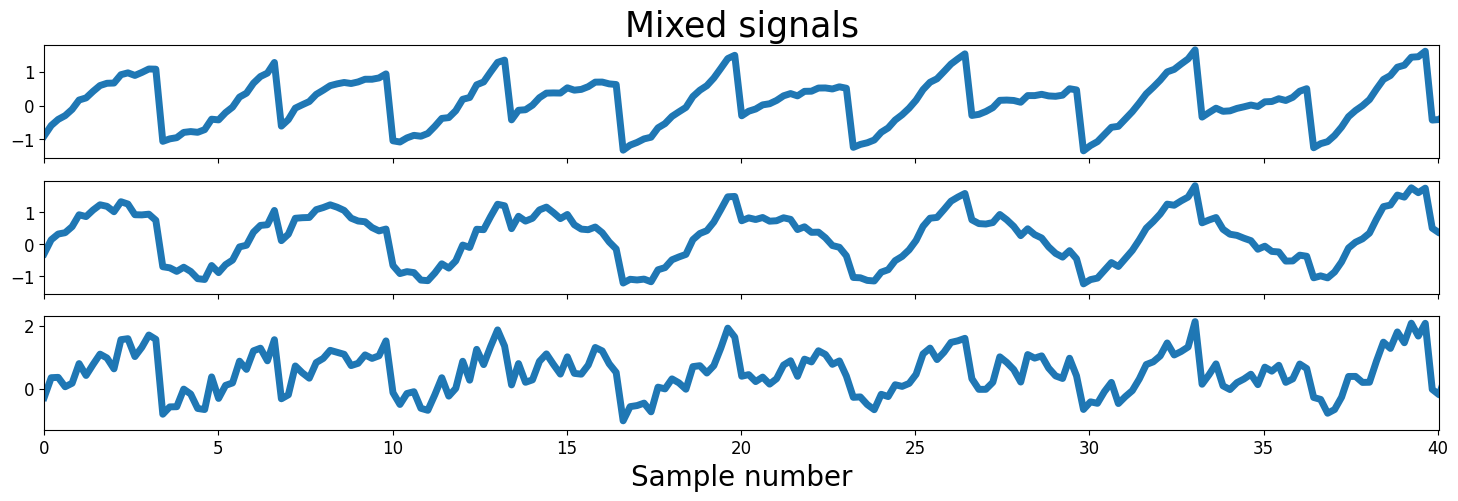

In [26]:
fig, ax = plt.subplots(3, 1, figsize=[18, 5], sharex=True)
ax[0].plot(ns, X[0], lw=5)
ax[0].set_title('Mixed signals', fontsize=25)
ax[0].tick_params(labelsize=12)

ax[1].plot(ns, X[1], lw=5)
ax[1].tick_params(labelsize=12)
ax[1].set_xlim(ns[0], ns[-1])

ax[2].plot(ns, X[2], lw=5)
ax[2].tick_params(labelsize=12)
ax[2].set_xlim(ns[0], ns[-1])
ax[2].set_xlabel('Sample number', fontsize=20)
ax[2].set_xlim(ns[0], ns[200])

plt.show()

Now I am going to use my ICA algorith to try to extract the independent components from these mixed signals.

In [157]:
## Defining the necessary functions for ICA
def g(x):
    return np.tanh(x)

def gprime(x):
    return 1 - np.tanh(x)**2

def center(X):
    return X - X.mean(axis=1, keepdims=True)

def covariance(X):
    m ,n=X.shape
    covariance_matrix=np.zeros((m,m))
    for i in range(m):
        X[i] = X[i] - X[i].mean()
        covariance_matrix[i,i]=np.var(X[i])

    for i in range(m):
        for j in range(i+1,m):
            covariance_matrix[i,j]=np.dot(X[i],X[j])/n
            covariance_matrix[j,i]=covariance_matrix[i,j]
    return covariance_matrix
        

def whitening(x):
    cov = covariance(x)
    d, E = np.linalg.eigh(cov)
    D = np.diag(d)
    D_inv = np.sqrt(np.linalg.inv(D))
    X_whiten = np.dot(E, np.dot(D_inv, np.dot(E.T, x)))
    return X_whiten

def calculate_new_w(w, X):
    w_new = (X * g(np.dot(w.T, X))).mean(axis=1) - gprime(np.dot(w.T, X)).mean() * w
    w_new /= np.sqrt((w_new ** 2).sum())
    return w_new

In [158]:
def ica (x, iterations):
    tolerance=1e-5
    x=whitening(x)
    number_of_components=x.shape[0]
    W=np.zeros((number_of_components,number_of_components),dtype=X.dtype)
    for i in range(number_of_components):
        w=np.random.rand(number_of_components)
        for j in range(iterations):
            w_new=calculate_new_w(w,x)
            if i>=1:
                w_new-=np.dot(np.dot(w_new,W[:i].T),W[:i])
            distance=np.abs(np.abs((w*w_new).sum())-1)
            w=w_new
            if distance<tolerance:
                break
        W[i,:]=w
    S=np.dot(W,x)
    return S,W
            

(3, 1000)


Text(0.5, 1.0, 'Recovered')

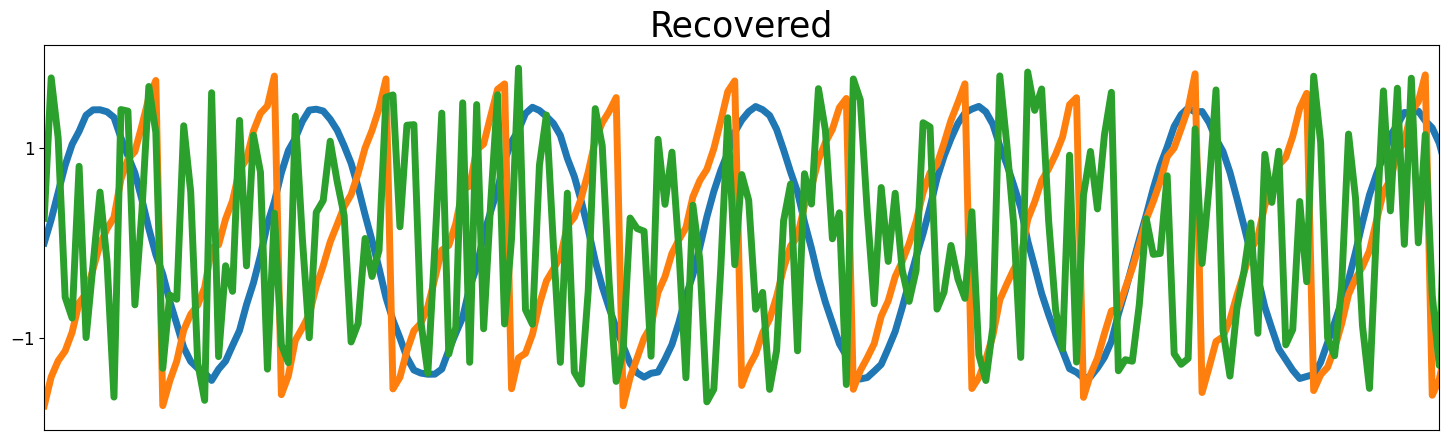

In [163]:
[y,z]=ica(X,1000)
print(y.shape)
## plot the first row of y
fig, ax=plt.subplots(1,1,figsize=(18,5))
ax.plot(ns, y[0], lw=5)
ax.plot(ns, y[1], lw=5)
ax.plot(ns, y[2], lw=5)
ax.set_xticks([])

ax.set_yticks([-1, 1])
ax.set_xlim(ns[0], ns[200])
ax.tick_params(labelsize=12)
ax.set_title('Recovered', fontsize=25)


To check if the properties discussed above also apply for our toy signals we will plot them accordingly. As expected the source signals are distributed on a square for non-Gaussian random variables. Likewise the mixed signals form a parallelogram in the right plot of Figure 3 which shows that the mixed signals are not independent anymore.
Here we hoped that the signals before applying mixing matrix were scattered on a square, and after that they form sth that shows they are not independent. That is exactly what happened here.


Covariance is basically the sum of the multiplication of x value and y value of each data point. So, if this summation value is positive, it means in the 2D plane our data are diagonally set from bottom left corner to the top right (like a line with a positive slope). The covariacne matrix is a 2x2 matrix, in which the first element is x-var, the last is y-var, and the two others on the non-main diagonal are the covariance.
## Whitenning
The second pre-processing method is called whitening. The goal here is to linearly transform the observed signals X in a way that potential correlations between the signals are removed and their variances equal unity. As a result the covariance matrix of the whitened signals will be equal to the identity matrix

Now it is time to look at the actual ICA algorithm. As discussed above one precondition for the ICA algorithm to work is that the source signals are non-Gaussian. Therefore the result of the ICA should return sources that are as non-Gaussian as possible. To achieve this we need a measure of Gaussianity. One way is Kurtosis and it could be used here but another way has proven more efficient. Nevertheless we will have a look at kurtosis at the end of this notebook. For the actual algorithm however we will use the equations g and g'.
g(u)=tanh(u)
g'(u)=1-tanh^2(u)
These equations allow an approximation of negentropy and will be used in the below ICA algorithm which is based on a fixed-point iteration scheme:

for 1 to number of components c:
wp=random initialization
while wp not < threshold :
wp=1/n(Xg(WT X)-g'(WT X)W)
w_p=w_p-∑_(j=1)^(p-1)▒〖(w_P^T W_J ) w_j 〗
wp=wp/||wp||
w=[w1...wc]
So according to the above what we have to do is to take a random guess for the weights of each component. The dot product of the random weights and the mixed signals is passed into the two functions g and g'. We then subtract the result of g' from g and calculate the mean. The result is our new weights vector. Next we could directly divide the new weights vector by its norm and repeat the above until the weights do not change anymore. There would be nothing wrong with that. However the problem we are facing here is that in the iteration for the second component we might identify the same component as in the first iteration. To solve this problem we have to decorrelate the new weights from the previously identified weights. This is what is happening in the step between updating the weights and dividing by their norm.